In [5]:
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials
import itertools

# Do not forget so space out the requests
spotify = spotipy.Spotify(
    client_credentials_manager=SpotifyClientCredentials())

# 1 - Build a population of artists

artist_map = {
    "11E9GHIAzJRKuECEUSEuqh": "Cheb Bello",  
    "3e3cKwH1kUr02bvIm7VaIe": "Kader Japonais",
    "5CZ5sGdn0X47HhndSYKqdz": "Cheba Dalila",
    "0c3dDCJfxcT4lYNugbKvJt": "Warda",
    "4iCrZzxACYPYcoS71DgjWW": "Bilal Sghir",
    "59N7N5tX53jyPhAmsRi4or": "Cheb Bilal",
    "4ZzMtjQsjtaAOm3GPqmjeQ" : "Cheb Djalil",
    "4l3uOQQa1NaZz7OVNAjbC2": "Cheb Houssem",
    "2zjXHi6RZyaS2t0P1BrxBs": "Cheb Mourad"
}

# 1.5 - Get basic artist info (Monthly listeners for instance)
selected_artists = spotify.artists(artist_map.keys()).get("artists")

# 2 - Get their top tracks
def get_track_id(track):
    return track.get("id")


all_tracks = list()
for artist_id in artist_map.keys():
    artist_albums = spotify.artist_albums(artist_id).get("items")
    for album in artist_albums:
        album_tracks = spotify.album_tracks(album.get("id")).get("items")
        full_tracks = spotify.tracks(list(map(get_track_id, album_tracks)))
        for track in full_tracks.get("tracks"):
            track["main_artist"] = artist_map.get(artist_id)
            all_tracks.append(track)

# 3 - Get maximum track features
tracks_ids = list(map(get_track_id, all_tracks))

def chunked_iterable(iterable, size):
    it = iter(iterable)
    while True:
        chunk = tuple(itertools.islice(it, size))
        if not chunk:
            break
        yield chunk

audio_features = list()

for track_ids_chunk in chunked_iterable(tracks_ids, 99):
    audio_features.extend(spotify.audio_features(tracks=track_ids_chunk))

# 4 - Store the data in a CSV file
# 5 - Create a notebook and explore the data

In [7]:
import pandas as pd 
import numpy as np

af = pd.DataFrame(audio_features)
tt = pd.DataFrame(all_tracks)

df = pd.merge(tt, af, how="left", on="id")
df = df[['id', 'name', 'main_artist', 'duration_ms_x', 'danceability', 'loudness', 'energy', 'instrumentalness', 'liveness', 'valence', 'speechiness', 'tempo','popularity']]
df = df.sort_values(by=['popularity'], ascending=False)

df.head()

,id,name,main_artist,duration_ms_x,danceability,loudness,energy,instrumentalness,liveness,valence,speechiness,tempo,popularity
51,1mhKtcpIVEwvE7qs32HcwI,Manich Kima Bakri,Cheb Bello,345652,0.705,-4.308,0.894,0.000005,0.0725,0.890,0.0950,96.066,47
71,049ryvt09w98K1uzsWf9x1,Frontières,Cheb Bello,209913,0.786,-3.735,0.863,0.000003,0.2500,0.455,0.0403,106.977,45
129,469RutojU2gIHm1bZvPKdp,Nti Sbabi,Kader Japonais,254491,0.469,-5.047,0.886,0.000000,0.1060,0.628,0.1710,176.154,44
170,6qlZjH5bLf6w6XvfpYxsPx,Mamamiya,Kader Japonais,229813,0.569,-5.111,0.992,0.053700,0.3950,0.558,0.0771,144.924,44
877,1ANh0Pyrr6axtL5PhoRqPh,Khatira Khatira,Cheb Houssem,582293,0.554,-7.417,0.826,0.002710,0.1200,0.873,0.0442,91.954,43


In [8]:
df.to_csv("out.csv", index=False)

## Correlations

Text(0.5, 1.0, 'Rai songs - Audio features and popularity - Correlation matrix')

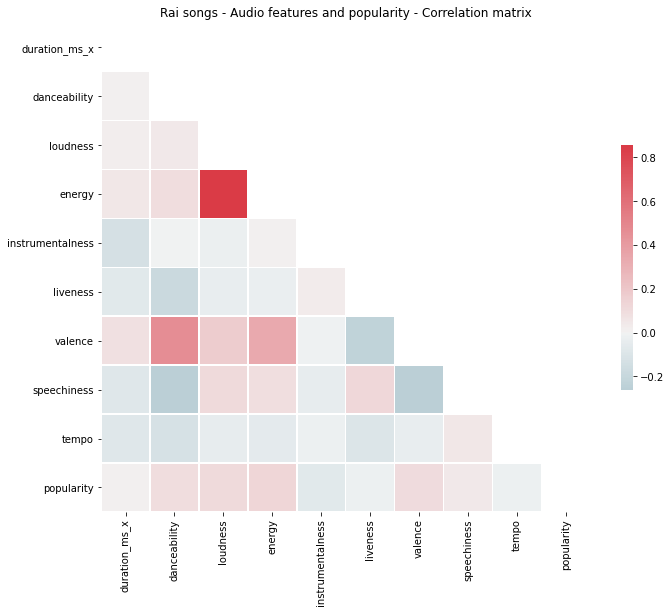

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt

df = df.loc[:, 'duration_ms_x':'popularity']
df = df.infer_objects()
corr = df.corr()
mask = np.triu(np.ones_like(corr, dtype=np.bool))
f, ax = plt.subplots(figsize=(11, 9))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
ax = sns.heatmap(corr, mask=mask, cmap=cmap, center=0, square=True, linewidths=.5, cbar_kws={"shrink": .5})
ax.set_title("Rai songs - Audio features and popularity - Correlation matrix")